# Data Analysis

In [145]:
import numpy as np
import pandas as pd

class DataAnalysis(object):
    def __init__(self, path):
        data_raw = pd.read_csv(path).drop("Index", axis = 1)
        self.data = data_raw.copy()
        self.data = self.data.loc[:, self.data.dtypes == "float64"]
        self.header = self.data.columns
        self.data = np.array(self.data.T)

    def compute_for_columns(self, function):
        row = []
        for col in self.data:
            row.append(function(col))
        return(row)

    def col_count(self, column):
        count = 0
        for i in column:
            if not np.isnan(i):
                count += 1
        return(count)

    def col_mean(self, column):
        col_sum = 0
        for i in column:
            if not np.isnan(i):
                col_sum += i
        return(col_sum/self.col_count(column))

    def col_std(self, column):
        mean = self.col_mean(column)
        return(np.sqrt(self.col_mean(np.square(column-mean))))

    def col_filter_nan(self, column):
        new_col = []
        for i in column:
            if not np.isnan(i):
                new_col.append(i)
        return(new_col)

    def col_sort(self, column):
        sorted_col = self.col_filter_nan(column)
        for i in range(1, len(sorted_col)):
            j = i-1
            nxt_element = sorted_col[i]
    # Compare the current element with next one
            while (sorted_col[j] > nxt_element) and (j >= 0):
                sorted_col[j+1] = sorted_col[j]
                j=j-1
            sorted_col[j+1] = nxt_element
        return(sorted_col)

    def col_min(self, column):
        return(self.col_sort(column)[0])

    def col_max(self, column):
        return(self.col_sort(column)[-1])

    def col_quantile(self, column, fraction):
        n = self.col_count(column)
        m = fraction*n
        sorted_col = self.col_sort(column)
        if np.floor(m) == m:
            return(sorted_col[int(m)])
        else:
            return((sorted_col[int(np.floor(m))] + sorted_col[int(np.ceil(m))])/2)

    def col_quantile_25(self, column):
        return(self.col_quantile(column,0.25))

    def col_median(self, column):
        return(self.col_quantile(column,0.5))

    def col_quantile_75(self, column):
        return(self.col_quantile(column,0.75))

    def describe_42(self):
        data_description = [self.compute_for_columns(self.col_count),
                            self.compute_for_columns(self.col_mean),
                           self.compute_for_columns(self.col_std),
                           self.compute_for_columns(self.col_min),
                           self.compute_for_columns(self.col_quantile_25),
                           self.compute_for_columns(self.col_median),
                           self.compute_for_columns(self.col_quantile_75),
                           self.compute_for_columns(self.col_max)]

        return pd.DataFrame(data_description,
                            index = ["count","mean","std","min","25","median","75", "max"], 
                            columns = self.header)


In [146]:
DataAnalysis('../data/dataset_train.csv').describe_42()

,Arithmancy,Astronomy,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Care of Magical Creatures,Charms,Flying
count,1566.000000,1568.000000,1567.000000,1569.000000,1561.00000,1565.000000,1565.000000,1557.000000,1566.000000,1570.000000,1560.000000,1600.000000,1600.000000
mean,49634.570243,39.797131,1.141020,-0.387863,3.15391,-224.589915,495.747970,2.963095,1030.096946,5.950373,-0.053427,-243.374409,21.958012
std,16674.479577,520.132330,5.218016,5.211132,4.15397,486.189433,106.251202,4.424353,44.111025,3.146852,0.971146,8.780895,97.601087
min,-24370.000000,-966.740546,-10.295663,-10.162119,-8.72700,-1086.496835,283.869609,-8.858993,906.627320,-4.697484,-3.313676,-261.048920,-181.470000
25,38513.000000,-489.493777,-4.308182,-5.251511,3.10000,-577.577682,397.526978,2.221199,1026.248273,3.648671,-0.670996,-250.647270,-41.840000
median,49018.000000,261.644731,3.477660,-2.581130,4.62450,-418.912644,464.122952,4.378897,1045.533335,5.877582,-0.043296,-244.867510,-2.510000
75,60873.000000,525.909540,5.422106,4.905750,5.66750,256.886191,597.598097,5.830729,1058.465401,8.251550,0.594446,-232.536750,50.890000
max,104956.000000,1016.211940,11.612895,9.667405,10.03200,1092.388611,745.396220,11.889713,1098.958201,13.536762,3.056546,-225.428140,279.070000


# Data Visualization

## Histograms

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
%matplotlib inline

class Histogram42(object):
    def __init__(self, path):
        data = pd.read_csv(path)
        if "Index" in data.columns :
            data.drop("Index", axis=1, inplace=True)
        
        self.gryffindor = data[data['Hogwarts House'] == 'Gryffindor']
        self.slytherin = data[data['Hogwarts House'] == 'Slytherin']
        self.ravenclaw = data[data['Hogwarts House'] == 'Ravenclaw']
        self.hufflepuff = data[data['Hogwarts House'] == 'Hufflepuff']
        
        self.courses = data.loc[:, data.dtypes == "float64"].columns
        
    def ks_test(self, course, verbose = True):
        list_of_tests = []
        list_of_tests.append(ks_2samp(self.gryffindor[course], self.slytherin[course])[1] < 0.05)
        list_of_tests.append(ks_2samp(self.gryffindor[course], self.ravenclaw[course])[1] < 0.05)
        list_of_tests.append(ks_2samp(self.gryffindor[course], self.hufflepuff[course])[1] < 0.05)
        list_of_tests.append(ks_2samp(self.slytherin[course], self.ravenclaw[course])[1] < 0.05)
        list_of_tests.append(ks_2samp(self.slytherin[course], self.hufflepuff[course])[1] < 0.05)
        list_of_tests.append(ks_2samp(self.ravenclaw[course], self.hufflepuff[course])[1] < 0.05)
        if list_of_tests == [True]*6:
            if verbose == True: 
                print("No distribution is the same")
            return 0
        elif list_of_tests == [False]*6:
            if verbose == True:
                print("All the distributions are the same")
            return 1  
        else: 
            if verbose == True:
                print("Some distributions are the same")
                print(list_of_tests)
            return 0

    def find_courses(self):
        results = []
        for course in self.courses:
            if self.ks_test(course, verbose = False) == 1:
                results.append(course)
        return results

    def plot_histogram(self):
        results = self.find_courses()
        if len(results) == 0:
            print("No course has a homogeneous repartition of the grades.")
        elif len(results) == 1:
            print("The only course having a homogeneous repartition of the grades is {0}".format(results[0]))
        else: 
            print("The courses that have a homogeneous repartition of the grades are {}.".format(' and '.join(results)))

        for result in results:
            fig, axes = plt.subplots(nrows=2, ncols=2)
            fig.suptitle(result, fontsize=14)
            fig.subplots_adjust(hspace=.5)
            self.ravenclaw[result].hist(bins=20, ax=axes[0, 0], figsize=(10,6)) ; axes[0, 0].set_title('Ravenclaw'); axes[0,0].set_xlabel('Grades')
            self.gryffindor[result].hist(bins=20, ax=axes[0, 1], figsize=(10,6)); axes[0, 1].set_title('Gryffindor'); axes[0,1].set_xlabel('Grades')
            self.hufflepuff[result].hist(bins=20, ax=axes[1, 0], figsize=(10,6)); axes[1, 0].set_title('Hufflepuff'); axes[1,0].set_xlabel('Grades')
            self.slytherin[result].hist(bins=20, ax=axes[1, 1], figsize=(10,6)); axes[1, 1].set_title('Slytherin'); axes[1,1].set_xlabel('Grades')

The courses that have a homogeneous repartition of the grades are Arithmancy and Care of Magical Creatures.


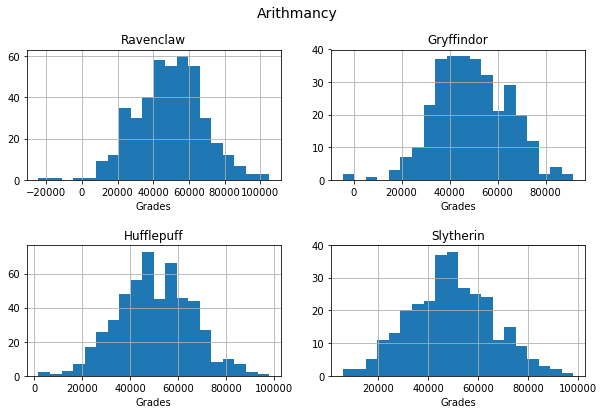

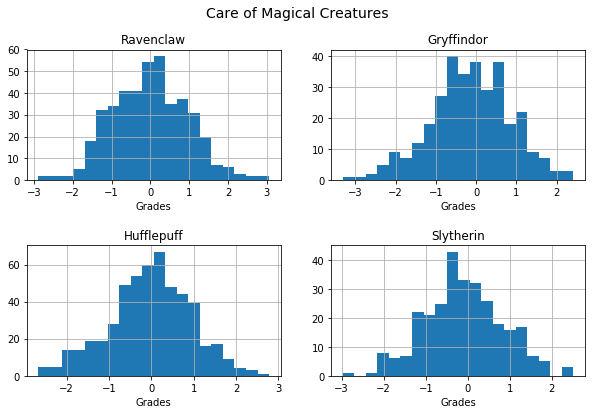

In [47]:
Histogram42('../data/dataset_train.csv').plot_histogram()

## Scatter-plot

In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp
%matplotlib inline

class ScatterPlot(object):
    def __init__(self, path):
        self.data = pd.read_csv(path)
        data = self.data
        if "Index" in data.columns :
            data.drop("Index", axis=1, inplace=True)
        
        self.gryffindor = data[data['Hogwarts House'] == 'Gryffindor']
        self.slytherin = data[data['Hogwarts House'] == 'Slytherin']
        self.ravenclaw = data[data['Hogwarts House'] == 'Ravenclaw']
        self.hufflepuff = data[data['Hogwarts House'] == 'Hufflepuff']
        
        self.courses = data.loc[:, data.dtypes == "float64"].columns
        
    def ks_test(self, course_1, course_2):
        pv_gryffindor = ks_2samp(self.gryffindor.loc[:, self.courses[course_1]], self.gryffindor.loc[:, self.courses[course_1 + course_2 + 1]])[1]
        pv_slytherin = ks_2samp(self.slytherin.loc[:, self.courses[course_1]], self.slytherin.loc[:, self.courses[course_1 + course_2 + 1]])[1]
        pv_hufflepuff = ks_2samp(self.hufflepuff.loc[:, self.courses[course_1]], self.hufflepuff.loc[:, self.courses[course_1 + course_2 + 1]])[1]
        pv_ravenclaw = ks_2samp(self.ravenclaw.loc[:, self.courses[course_1]], self.ravenclaw.loc[:, self.courses[course_1 + course_2 + 1]])[1]
        pv_final = pv_gryffindor*pv_slytherin*pv_hufflepuff*pv_ravenclaw
        return(pv_final)
    
    def find_similar_courses(self, verbose = False):
        results = []
        for course_1 in range(len(self.courses)-1):
            for course_2 in range(len(self.courses) - course_1 - 1):
                results.append([self.courses[course_1], self.courses[course_1 + course_2 + 1],self.ks_test(course_1,course_2)])
        return np.array(results)[np.array(results)[:,2].argsort()][::-1][0]

    def plot_histogram(self):
        results = self.find_similar_courses()
        print(results[0],"and",results[1],"are the most similar courses")
        print("Kolmogorov–Smirnov test applied to find similarity of distribution of the grades in two courses, in each of the four houses")
        
        fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
        fig.suptitle(results[0], fontsize=14)
        fig.subplots_adjust(hspace=.5)
        
        axes[0,0].scatter(self.gryffindor[results[0]], self.gryffindor[results[0]]*0, label = results[0]);
        axes[0,0].scatter(self.gryffindor[results[1]], self.gryffindor[results[1]]*0+1, label = results[1]);
        
        axes[1,0].scatter(self.slytherin[results[0]], self.slytherin[results[0]]*0, label = results[0]);
        axes[1,0].scatter(self.slytherin[results[1]], self.slytherin[results[1]]*0+1, label = results[1]);

        axes[0,1].scatter(self.ravenclaw[results[0]], self.ravenclaw[results[0]]*0, label = results[0]);
        axes[0,1].scatter(self.ravenclaw[results[1]], self.ravenclaw[results[1]]*0+1, label = results[1]);
        
        axes[1,1].scatter(self.hufflepuff[results[0]], self.hufflepuff[results[0]]*0, label = results[0]);
        axes[1,1].scatter(self.hufflepuff[results[1]], self.hufflepuff[results[1]]*0+1, label = results[1]);
        
        houses = ['Gryffindor','Slytherin', 'Ravenclaw', 'Hufflepuff']
        for i in range(0,2):
            for j in range(0,2):
                plot = axes[i,j]
                idx = i+j
                plot.set_title(houses[idx]);
                plot.set_xlabel('Grades distribution')
                plot.set_ylim(-1,2)
                plot.get_yaxis().set_visible(False)
                plot.legend(loc='upper left')
        
        

Herbology and History of Magic are the most similar courses
Kolmogorov–Smirnov test applied to find similarity of distribution of the grades in two courses, in each of the four houses


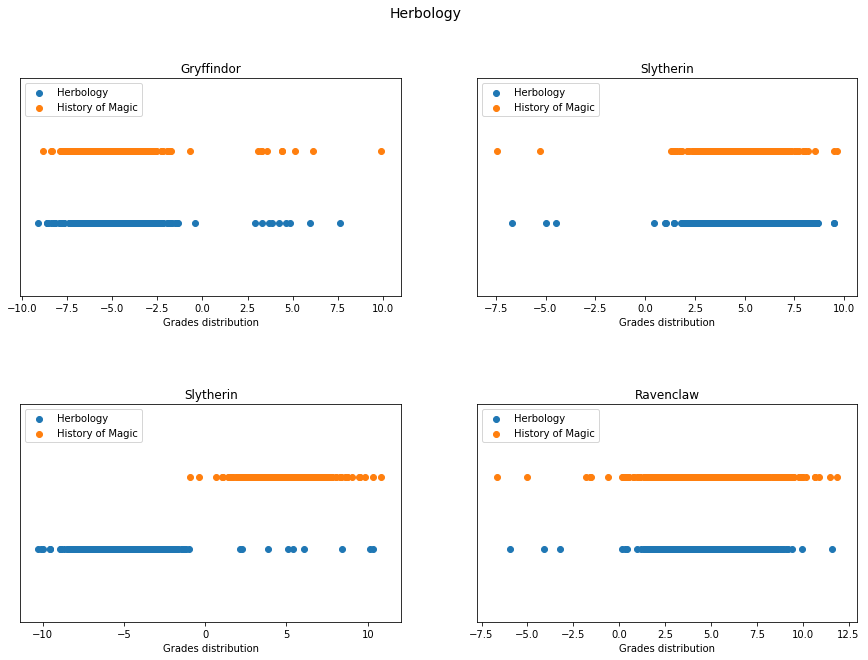

In [285]:
ScatterPlot('../data/dataset_train.csv').plot_histogram()

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
%matplotlib inline

path = '../data/dataset_train.csv'
data = pd.read_csv(path)
if "Index" in data.columns :
    data.drop("Index", axis=1, inplace=True)

data = data.loc[:, data.dtypes == "float64"]
    
courses = data.loc[:, data.dtypes == "float64"].columns
same_features = []

for course_1 in range(len(courses)-1):
    for course_2 in range(len(courses) - course_1 - 1):
        print([courses[course_1], courses[course_1 + course_2 + 1]])
        print(ks_2samp(data.loc[:, courses[course_1]], data.loc[:, courses[course_1 + course_2 + 1]]))
        #if ks_2samp(data.loc[:, courses[course_1]], data.loc[:, courses[course_1 + course_2 + 1]])[1] > 0.05:
        #    same_features.append([courses[course_1], courses[course_1 + course_2 + 1]])
        

['Arithmancy', 'Astronomy']
Ks_2sampResult(statistic=0.97687499999999994, pvalue=0.0)
['Arithmancy', 'Herbology']
Ks_2sampResult(statistic=0.97624999999999995, pvalue=0.0)
['Arithmancy', 'Defense Against the Dark Arts']
Ks_2sampResult(statistic=0.97749999999999992, pvalue=0.0)
['Arithmancy', 'Divination']
Ks_2sampResult(statistic=0.97249999999999992, pvalue=0.0)
['Arithmancy', 'Muggle Studies']
Ks_2sampResult(statistic=0.97499999999999998, pvalue=0.0)
['Arithmancy', 'Ancient Runes']
Ks_2sampResult(statistic=0.97499999999999998, pvalue=0.0)
['Arithmancy', 'History of Magic']
Ks_2sampResult(statistic=0.96999999999999997, pvalue=0.0)
['Arithmancy', 'Transfiguration']
Ks_2sampResult(statistic=0.97562499999999996, pvalue=0.0)
['Arithmancy', 'Potions']
Ks_2sampResult(statistic=0.97812499999999991, pvalue=0.0)
['Arithmancy', 'Care of Magical Creatures']
Ks_2sampResult(statistic=0.97187499999999993, pvalue=0.0)
['Arithmancy', 'Charms']
Ks_2sampResult(statistic=0.99687499999999996, pvalue=0.0)


In [26]:
same_features

[]

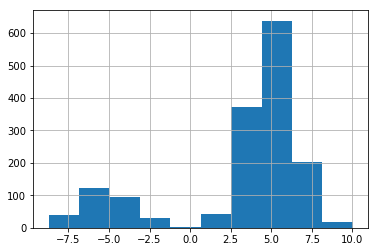

In [30]:
data['Divination'].hist()

'Slytherin'